## This notebook used SMOTE to first undersample majarity class and then oversample minority class
!NOTE: this notebook needs to be ran on large memory CPU node

In [1]:
import imblearn
import os
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
from matplotlib import pyplot
import category_encoders as ce
from collections import Counter

In [2]:
data_dir = "/global/homes/z/zimingy/KE-Catboost/ziming/GO/data/go_aggregated_4.1"
data_file = os.path.join(data_dir, 'go_aggregated_4.1_mixed_updated_normalized.pkl')
output_pickle = os.path.join(data_dir, 'go_aggregated_4.1_mixed_updated_normalized_balanced.pkl')
output_tsv = os.path.join(data_dir, 'go_aggregated_4.1_mixed_updated_normalized_balanced.tsv')

## Load original imbalanced dataset

In [3]:
%%time
df = pd.read_pickle(data_file)
null_vals = df.isnull().sum(axis=0)
assert len(null_vals[null_vals != 0]) == 0
df.drop(['version'], inplace=True, axis=1)
df

CPU times: user 7.51 s, sys: 1.19 s, total: 8.7 s
Wall time: 2.56 s


,id,study_id,sample_id,biome,exptype,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
19,ERZ650344,MGYS00003358,SRS3210273,root:Environmental:Aquatic:Marine:Brackish,assembly,0.001284,0.0,0.0,0.001645,0.004742,...,0.037736,0.002090,0.008326,0.0,0.000443,0.0,0.0,0.0,0.003937,0.003554
27,ERZ747221,MGYS00004737,SRS1791943,root:Engineered:Biogas plant,assembly,0.020967,0.0,0.0,0.002165,0.009009,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
29,ERZ761615,MGYS00003390,SRS1984850,root:Engineered:Bioreactor,assembly,0.000856,0.0,0.0,0.001299,0.013751,...,0.622642,0.002699,0.000185,0.0,0.000952,0.0,0.0,0.0,0.004208,0.004583
30,ERR2193276,MGYS00005065,ERS2001073,root:Host-associated:Mammals,metagenomic,0.000000,0.0,0.0,0.000125,0.000000,...,0.000000,0.000318,0.000093,0.0,0.000332,0.0,0.0,0.0,0.000362,0.000468
31,ERR2193277,MGYS00005065,ERS2001074,root:Host-associated:Mammals,metagenomic,0.000000,0.0,0.0,0.000149,0.000000,...,0.000000,0.000344,0.000093,0.0,0.000443,0.0,0.0,0.0,0.000452,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73785,ERZ807429,MGYS00005443,ERS1960449,root:Host-associated:Human:Digestive system:Oral,assembly,0.000000,0.0,0.0,0.000014,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000094
74255,ERZ795020,MGYS00004901,SRS785549,root:Engineered:Wastewater,assembly,0.000000,0.0,0.0,0.000553,0.001422,...,0.018868,0.000265,0.000000,0.0,0.000022,0.0,0.0,0.0,0.001855,0.000748
74256,ERZ505245,MGYS00003223,SRS1589217,root:Environmental:Aquatic:Marine,assembly,0.000428,0.0,0.0,0.001617,0.003319,...,0.056604,0.001429,0.000093,0.0,0.000155,0.0,0.0,0.0,0.003982,0.005238
74261,ERZ505291,MGYS00003237,SRS1589396,root:Environmental:Aquatic:Marine,assembly,0.000856,0.0,0.0,0.001439,0.001897,...,0.037736,0.001535,0.000000,0.0,0.000244,0.0,0.0,0.0,0.003348,0.004957


In [4]:
y = df.loc[:, 'biome']
X = df[df.columns[4:]]


## print biomes freq and bar plot

In [5]:
counter = Counter(y).most_common()
for k,v in counter:
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=root:Host-associated:Human:Digestive system:Large intestine:Fecal, n=14778 (46.269%)
Class=root:Host-associated:Human:Digestive system, n=3619 (11.331%)
Class=root:Host-associated:Human:Skin, n=2728 (8.541%)
Class=root:Mixed:Sediment:Sediment:Sediment, n=1993 (6.240%)
Class=root:Environmental:Aquatic:Marine, n=1386 (4.340%)
Class=root:Host-associated:Human:Digestive system:Large intestine, n=1266 (3.964%)
Class=root:Host-associated:Animal:Digestive system:Fecal, n=478 (1.497%)
Class=root:Host-associated:Human:Digestive system:Large intestine:Sigmoid colon, n=400 (1.252%)
Class=root:Host-associated:Human:Digestive system:Intestine, n=390 (1.221%)
Class=root:Environmental:Aquatic:Marine:Oceanic, n=348 (1.090%)
Class=root:Engineered:Wastewater, n=298 (0.933%)
Class=root:Host-associated:Human, n=295 (0.924%)
Class=root:Environmental:Terrestrial:Soil, n=285 (0.892%)
Class=root:Host-associated:Mammals:Digestive system:Fecal, n=223 (0.698%)
Class=root:Host-associated:Mammals:Gastrointes

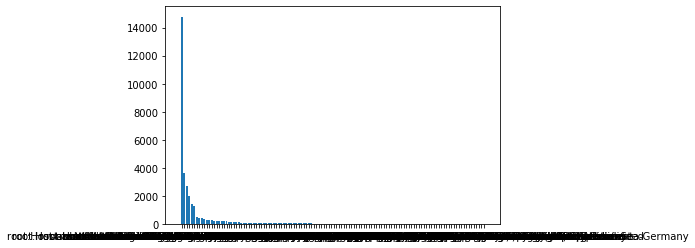

In [6]:
pyplot.bar(dict(counter).keys(), dict(counter).values())
pyplot.show()

In [7]:
## remove data with freq=1
low_freq_biome_names = []
for biome, freq in counter:
    if freq < 5 :
        low_freq_biome_names.append(biome)

In [8]:
## get low freq biome indexes
low_freq_biome_indexes = df[df['biome'].isin(low_freq_biome_names)].index
## drop low freq biome samples
df = df.drop(low_freq_biome_indexes)
y_droped = df.loc[:, 'biome']
X_droped = df[df.columns[4:]]

## Encode categarical features

In [9]:
%%time
encoder= ce.OrdinalEncoder(mapping=[
{'col': 'exptype', 'mapping': {'assembly': 0, 'metagenomic': 1}}
])
X_encoded = encoder.fit_transform(X_droped)
X_encoded

CPU times: user 3.47 s, sys: 4.49 s, total: 7.96 s
Wall time: 261 ms


,exptype,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0007026,GO:0005976,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
19,0,0.001284,0.0,0.0,0.001645,0.004742,0.000359,0.001137,0.0,0.001163,...,0.037736,0.002090,0.008326,0.0,0.000443,0.0,0.0,0.0,0.003937,0.003554
27,0,0.020967,0.0,0.0,0.002165,0.009009,0.000020,0.002570,0.0,0.001454,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
29,0,0.000856,0.0,0.0,0.001299,0.013751,0.001038,0.001264,0.0,0.001725,...,0.622642,0.002699,0.000185,0.0,0.000952,0.0,0.0,0.0,0.004208,0.004583
30,1,0.000000,0.0,0.0,0.000125,0.000000,0.000180,0.000084,0.0,0.000291,...,0.000000,0.000318,0.000093,0.0,0.000332,0.0,0.0,0.0,0.000362,0.000468
31,1,0.000000,0.0,0.0,0.000149,0.000000,0.000200,0.000126,0.0,0.000291,...,0.000000,0.000344,0.000093,0.0,0.000443,0.0,0.0,0.0,0.000452,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73785,0,0.000000,0.0,0.0,0.000014,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000094
74255,0,0.000000,0.0,0.0,0.000553,0.001422,0.000000,0.000169,0.0,0.000310,...,0.018868,0.000265,0.000000,0.0,0.000022,0.0,0.0,0.0,0.001855,0.000748
74256,0,0.000428,0.0,0.0,0.001617,0.003319,0.000020,0.000969,0.0,0.001396,...,0.056604,0.001429,0.000093,0.0,0.000155,0.0,0.0,0.0,0.003982,0.005238
74261,0,0.000856,0.0,0.0,0.001439,0.001897,0.000040,0.000716,0.0,0.001280,...,0.037736,0.001535,0.000000,0.0,0.000244,0.0,0.0,0.0,0.003348,0.004957


## SMOTE undersampling

In [10]:
## build the sampling_strategy argument dictionary
sampling_strategy_dict = {
                          "root:Host-associated:Human:Digestive system:Large intestine:Fecal": 1000,
                          "root:Host-associated:Human:Digestive system": 1000,
                          "root:Host-associated:Human:Skin":1000,
                          "root:Mixed:Sediment:Sediment:Sediment":1000,
                          "root:Environmental:Aquatic:Marine":1000,
                          "root:Host-associated:Human:Digestive system:Large intestine":1000
                        }

In [11]:
%%time
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy_dict)
X_undersampled, y_undersampled = under_sampler.fit_resample(X_encoded, y_droped)

CPU times: user 9.56 s, sys: 2.21 s, total: 11.8 s
Wall time: 1.94 s


In [12]:
counter_undersampled = Counter(y_undersampled).most_common()
for k,v in counter_undersampled:
    per = v / len(y_undersampled) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=root:Environmental:Aquatic:Marine, n=1000 (8.265%)
Class=root:Host-associated:Human:Digestive system, n=1000 (8.265%)
Class=root:Host-associated:Human:Digestive system:Large intestine, n=1000 (8.265%)
Class=root:Host-associated:Human:Digestive system:Large intestine:Fecal, n=1000 (8.265%)
Class=root:Host-associated:Human:Skin, n=1000 (8.265%)
Class=root:Mixed:Sediment:Sediment:Sediment, n=1000 (8.265%)
Class=root:Host-associated:Animal:Digestive system:Fecal, n=478 (3.951%)
Class=root:Host-associated:Human:Digestive system:Large intestine:Sigmoid colon, n=400 (3.306%)
Class=root:Host-associated:Human:Digestive system:Intestine, n=390 (3.223%)
Class=root:Environmental:Aquatic:Marine:Oceanic, n=348 (2.876%)
Class=root:Engineered:Wastewater, n=298 (2.463%)
Class=root:Host-associated:Human, n=295 (2.438%)
Class=root:Environmental:Terrestrial:Soil, n=285 (2.356%)
Class=root:Host-associated:Mammals:Digestive system:Fecal, n=223 (1.843%)
Class=root:Host-associated:Mammals:Gastrointestin

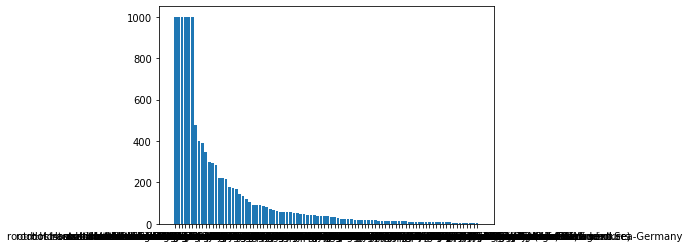

In [13]:
pyplot.bar(dict(counter_undersampled).keys(), dict(counter_undersampled).values())
pyplot.show()

## SMOTE undersampling

In [14]:
%%time
over_sampler =  RandomOverSampler(sampling_strategy='not majority')
X_oversampled, y_oversampled = over_sampler.fit_resample(X_undersampled, y_undersampled)

CPU times: user 22 s, sys: 7.07 s, total: 29 s
Wall time: 10.8 s


In [15]:
counter_oversampled = Counter(y_oversampled).most_common()
for k,v in counter_oversampled:
    per = v / len(y_oversampled) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=root:Engineered:Biogas plant, n=1000 (1.111%)
Class=root:Engineered:Biogas plant:Wet fermentation, n=1000 (1.111%)
Class=root:Engineered:Bioreactor, n=1000 (1.111%)
Class=root:Engineered:Bioreactor:Continuous culture:Marine sediment inoculum:Wadden Sea-Germany, n=1000 (1.111%)
Class=root:Engineered:Bioremediation:Terephthalate:Wastewater, n=1000 (1.111%)
Class=root:Engineered:Built environment, n=1000 (1.111%)
Class=root:Engineered:Food production, n=1000 (1.111%)
Class=root:Engineered:Food production:Dairy products, n=1000 (1.111%)
Class=root:Engineered:Food production:Fermented beverages, n=1000 (1.111%)
Class=root:Engineered:Food production:Fermented vegetables, n=1000 (1.111%)
Class=root:Engineered:Modeled:Simulated communities (microbial mixture), n=1000 (1.111%)
Class=root:Engineered:Modeled:Simulated communities (sequence read mixture), n=1000 (1.111%)
Class=root:Engineered:Solid waste:Composting, n=1000 (1.111%)
Class=root:Engineered:Wastewater, n=1000 (1.111%)
Class=root

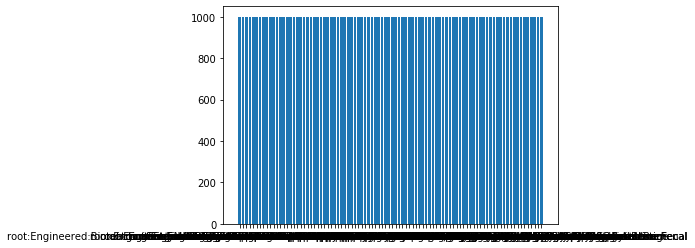

In [16]:
pyplot.bar(dict(counter_oversampled).keys(), dict(counter_oversampled).values())
pyplot.show()

In [17]:
X_oversampled.insert(loc=0, column='biome', value=y_oversampled)
X_oversampled

,biome,exptype,GO:0043130,GO:0055074,GO:0055117,GO:0046933,GO:0006302,GO:0008643,GO:0043752,GO:0007026,...,GO:0019357,GO:0006527,GO:0004114,GO:0046423,GO:0034194,GO:0032183,GO:0007618,GO:0030097,GO:0004520,GO:0033739
0,root:Engineered:Biogas plant,0,0.020967,0.0,0.0,0.002165,0.009009,0.000020,0.002570,0.0,...,0.037736,0.002910,0.000000,0.0,0.000332,0.0,0.0,0.0,0.009231,0.003180
1,root:Engineered:Biogas plant,0,0.027386,0.0,0.0,0.002714,0.010431,0.000040,0.003160,0.0,...,0.056604,0.003254,0.000278,0.0,0.000310,0.0,0.0,0.0,0.011538,0.003835
2,root:Engineered:Biogas plant,0,0.001712,0.0,0.0,0.004133,0.031769,0.000759,0.006024,0.0,...,0.245283,0.003810,0.000833,0.0,0.000199,0.0,0.0,0.0,0.025928,0.004583
3,root:Engineered:Biogas plant,0,0.000000,0.0,0.0,0.002146,0.021811,0.000180,0.003370,0.0,...,0.037736,0.001349,0.000000,0.0,0.000089,0.0,0.0,0.0,0.014932,0.001871
4,root:Engineered:Biogas plant,0,0.001712,0.0,0.0,0.005841,0.038407,0.000958,0.006698,0.0,...,0.547170,0.004392,0.000000,0.0,0.000532,0.0,0.0,0.0,0.029367,0.007576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,root:Host-associated:Porifera,1,0.007702,0.0,0.0,0.021603,0.014225,0.002696,0.023044,0.0,...,0.000000,0.008784,0.021926,0.0,0.000089,0.0,0.0,0.0,0.078778,0.035170
89996,root:Host-associated:Porifera,1,0.024818,0.0,0.0,0.004508,0.000000,0.000240,0.004297,0.0,...,0.000000,0.002858,0.002035,0.0,0.001196,0.0,0.0,0.0,0.019095,0.011505
89997,root:Host-associated:Porifera,1,0.028241,0.0,0.0,0.001540,0.009009,0.002536,0.000758,0.0,...,0.000000,0.000106,0.035248,0.0,0.000997,0.0,0.0,0.0,0.003891,0.001216
89998,root:Host-associated:Porifera,1,0.000000,0.0,0.0,0.000019,0.000000,0.000000,0.000042,0.0,...,0.000000,0.000026,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000181,0.000094


In [ ]:
X_oversampled.to_pickle(output_pickle)
X_oversampled.to_csv(output_tsv)